# Objective:
Crop out the image of a car from a background using machine learning.

# Outcome:
On average, we are correctly classifying 99.25% of the time! (Calculated using Dice Score) 

# In this script:
We define the file paths to your image and mask folders.
We create a CNN model for image segmentation using Keras. This is a simple U-Net-like architecture.
We compile the model with appropriate loss and metrics for binary segmentation.
We define a function load_and_preprocess_image_mask to load, resize, and preprocess images and masks.
We load and preprocess the training data, storing images and masks in NumPy arrays.
We train the model on the data for a specified number of epochs.
Finally, we save the trained model for future use.
Make sure to adjust the input_shape, model architecture, and hyperparameters as needed for your specific task. Also, consider using a larger dataset if available for better performance.

# Step1: Define filepaths for the images and masks

In [81]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define file paths
image_folder = "/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train"
mask_folder = "/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train_masks"

# Get a list of image and mask file paths
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(".jpg")]
mask_paths = [os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder) if fname.endswith(".gif")]
# Sort into abc order - masks and images have same names so they can be matched easily later
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)

print('Length of image_paths\n', len(image_paths))
print('First few image paths:\n', image_paths[0:3])
print('Shape of mask_folder\n', len(mask_paths))
print('First few mask paths:\n', mask_paths[0:3])


Length of image_paths
 5088
First few image paths:
 ['/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train/00087a6bd4dc_01.jpg', '/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train/00087a6bd4dc_02.jpg', '/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train/00087a6bd4dc_03.jpg']
Shape of mask_folder
 5088
First few mask paths:
 ['/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train_masks/00087a6bd4dc_01_mask.gif', '/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train_masks/00087a6bd4dc_02_mask.gif', '/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train_masks/00087a6bd4dc_03_mask.gif']


# Step 2: Import images as NP arrays  

5000
4000
1000
4000
1000
/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train/fce0ba5b8ed7_08.jpg
/Users/maycaj/Documents/Hyperspectral-Imaging/Carvana_input/train_masks/fce0ba5b8ed7_08_mask.gif
(256, 256, 3)
(256, 256)
The array contains only 1s and 0s.


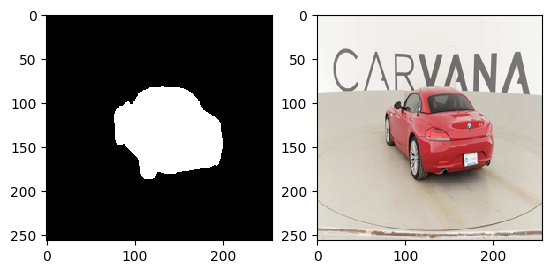

In [82]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define a function to load and preprocess images and masks
def load_and_preprocess_image_mask(image_path, mask_path, input_shape=(256, 256)):
    # Open the image using PIL and resize it
    image_opened = Image.open(image_path).resize(input_shape)
    # Convert the PIL image to a NumPy array
    image = np.array(image_opened)
    # Normalize the image to the range [0, 1]
    image = image / 255.0

    # Open the mask image using PIL and resize it
    mask_opened = Image.open(mask_path).resize(input_shape)
    mask = np.array(mask_opened)
    
    return image, mask

# Load and preprocess data
images = []
masks = []
input_shape = (256, 256)  # Set your desired target size here

for image_path, mask_path in zip(image_paths, mask_paths):
    image, mask = load_and_preprocess_image_mask(image_path, mask_path, input_shape=input_shape)
    images.append(image)
    masks.append(mask)
    # Increment the counter due to memory issues
    if len(images) == 5000:
        break
    
# Convert lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)

# Divide into testing and training and X and y
total = len(images)
X_train = images[0:int(0.8*total)]
X_test = images[int(0.8*total):total]
y_train = masks[0:int(0.8*total)]
y_test = masks[int(0.8*total):total]
print(total)
print(len(X_train))
print((len(X_test)))
print((len(y_train)))
print((len(y_test)))

# show last filepath & image and mask shape
# print(image_path)
# print(mask_path)
# print(image.shape)
# print(mask.shape)

# show last image
plt.subplot(1,2,1)
plt.imshow(mask, interpolation='nearest', cmap='gray')
plt.subplot(1,2,2)
plt.imshow(image, interpolation='nearest')

# Check if all elements in the mask are either 0 or 1 (needed for binary_crossentropy)
# is_binary = np.all(np.logical_or(mask == 0, mask == 1))
# if is_binary:
#     print("The array contains only 1s and 0s.")
# else:
#     print("The array contains values other than 1 and 0.")

# Step 3: Define the Model 

In [84]:

# Define model parameters
input_shape_model = input_shape + (3,)  # add the 3rd dimension (RGB) on top of input_shape
print(input_shape_model)
num_classes = 1  # Binary classification (car or background)

# Define the CNN model
model = keras.Sequential([
    layers.Input(shape=input_shape_model),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(size=(2, 2)), # upsampling increases the resolution of a feature map. Here, the x and y dimensions both double in resolution
    layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(size=(2, 2)),
    layers.Conv2D(num_classes, (1, 1), activation='sigmoid', padding='same')
])
model.summary()

# perhapse we can use a dice score instead of binary_crossentropy is not working
# Dice coefficient is 2 times The area of Overlap divided by the total number of pixels in both the images
# import keras.backend as K

# def dice_loss(y_true, y_pred):
#     intersection = K.sum(y_true * y_pred) # sums the number of pixels where both y_true and y_pred have the same value
#     union = K.sum(y_true) + K.sum(y_pred)
#     dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
#     return 1.0 - dice

# # Compile the model using the custom Dice loss
# model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


(256, 256, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 

In [85]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=5, #patience=5 means the learning rate will be reduced if the validation accuracy does not improve for 5 epochs.
                                            verbose=1, #0=no learning updates, 1=learning updates
                                            factor=0.5, # learning rate is decreased by a half
                                            min_lr=1e-7) 

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, 
           verbose=1, callbacks = [learning_rate_reduction])

# Save the trained model for future use
model.save("car_mask_model.keras")

Epoch 1/10
100/100 [==============================] - 210s 2s/step - loss: 0.2687 - accuracy: 0.8836 - val_loss: 0.0905 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 214s 2s/step - loss: 0.0600 - accuracy: 0.9755 - val_loss: 0.0425 - val_accuracy: 0.9818 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - 213s 2s/step - loss: 0.0339 - accuracy: 0.9860 - val_loss: 0.0296 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - 211s 2s/step - loss: 0.0268 - accuracy: 0.9889 - val_loss: 0.0228 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 5/10
100/100 [==============================] - 211s 2s/step - loss: 0.0237 - accuracy: 0.9902 - val_loss: 0.0208 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 6/10
100/100 [==============================] - 211s 2s/step - loss: 0.0214 - accuracy: 0.9912 - val_loss: 0.0201 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 7/10
100/100 [==============================] - 212s 2s/st

# Step 4: Display metrics from training 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


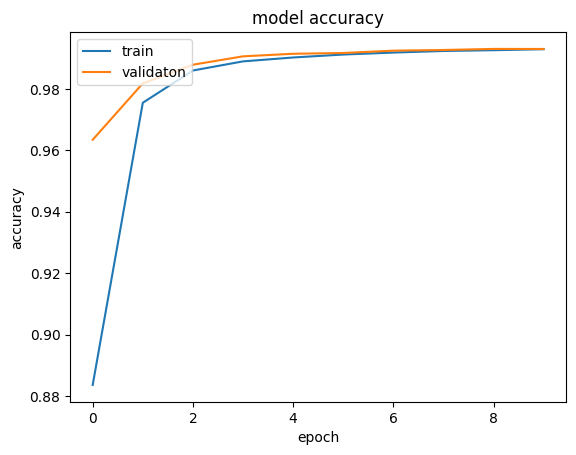

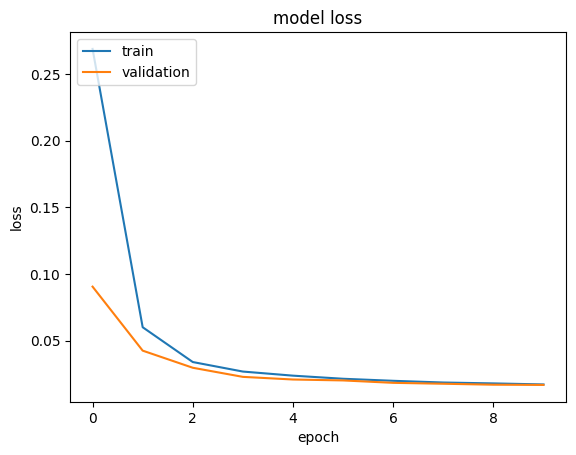

In [86]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validaton'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Step 5: Test model on testing data, show outputs, compute accuracy

In [87]:
y_pred = model.predict(X_test)
print('(Number of images, x dimension, y dimension, greyscale dimension):\n',y_pred.shape)

32/32 [==============================] - 20s 633ms/step
(Number of images, x dimension, y dimension, greyscale dimension):
 (1000, 256, 256, 1)


In [88]:
y_pred.shape
len(y_pred)

1000

In [89]:
y_pred[1] = np.round(y_pred[1])
# print(y_pred[1])
# _____ round the rest of the images in y_pred

# def round_image(image):
#     rounded_image = np.round(image)
#     return rounded_image
print(y_pred.shape)

y_pred_rounded = []
for i in range((len(y_pred))):
    rounded_image = np.round(y_pred[i])
    y_pred_rounded.append(rounded_image)

print(y_pred.shape)
print(len(y_pred_rounded))

(1000, 256, 256, 1)
(1000, 256, 256, 1)
1000


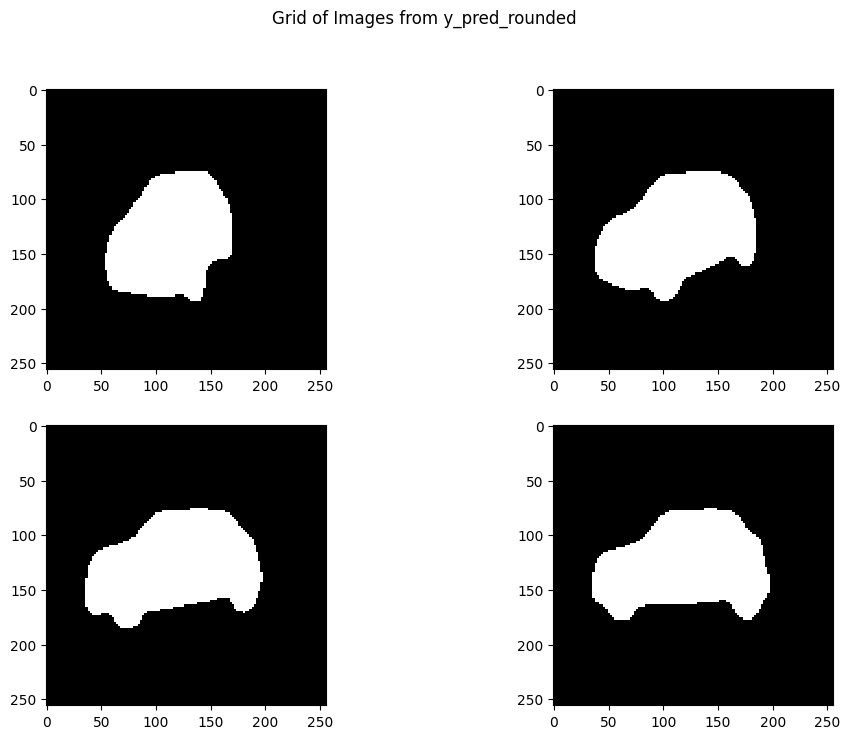

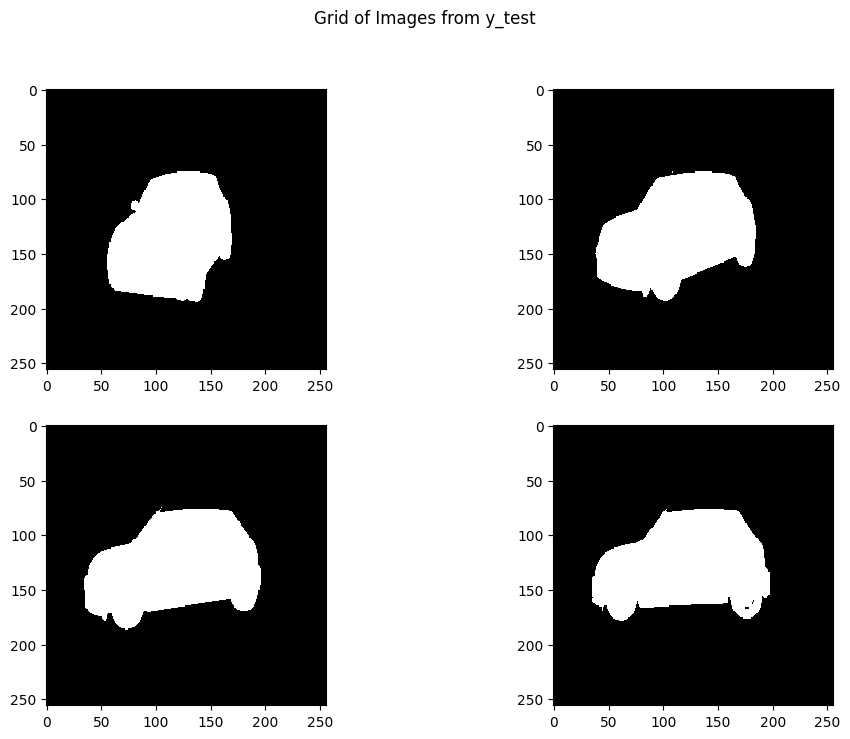

In [90]:
# Display first 4 outputs
fig_pred = plt.figure(figsize=(12, 8))
columns = 2
rows = 2

for i in range(1, columns*rows +1):
    ax = fig_pred.add_subplot(rows, columns, i)
    plt.imshow(y_pred_rounded[i], cmap='gray', interpolation='nearest')
plt.suptitle("Grid of Images from y_pred_rounded")
plt.show()

fig_test = plt.figure(figsize=(12, 8))
for i in range(1, columns*rows +1):
    ax = fig_test.add_subplot(rows, columns, i)
    plt.imshow(y_test[i], cmap='gray', interpolation='nearest')
plt.suptitle("Grid of Images from y_test")
plt.show()

In [91]:
import numpy as np

def dice_compute(y_test_image, y_pred_image):
    # Assuming y_test_image and y_pred_image are NumPy arrays with the same shape (256, 256)
    total_values = input_shape[0]*input_shape[1]
    # Initialize intersection count
    intersection_count = 0
    # Iterate through each pixel and compare values
    for i in range(input_shape[0]):
        for j in range(input_shape[1]):
            if y_test_image[i, j] == y_pred_image[i, j]:
                intersection_count += 1
    dice_score = 2 * (intersection_count / (2 * total_values))
    return dice_score

dice_scores = []
for i in range(len(y_pred_rounded)):
    dice_score = dice_compute(y_test[i], y_pred_rounded[i])
    dice_scores.append(dice_score)

average_dice_score = sum(dice_scores) / len(dice_scores)
print('Average dice score:\n', average_dice_score)


Average dice score:
 0.9925200653076172


(256, 256, 3)


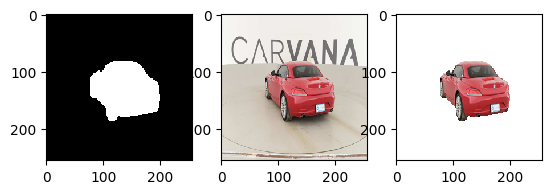

In [99]:
def remove_background(original_image, mask):
    cropped_image = original_image.copy()  # Create a copy to avoid modifying the original image
    for i in range(input_shape[0]):
        for j in range(input_shape[1]):
            if mask[i, j] == 0:  # If the mask is black (we are at the background)
                cropped_image[i, j] = 1  # Set the pixel to white
    return cropped_image

cropped_image = remove_background(image, mask)
print(cropped_image.shape)

plt.subplot(1,3,1)
plt.imshow(mask, interpolation='nearest', cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image, interpolation='nearest')
plt.subplot(1,3,3)
plt.imshow(cropped_image, interpolation='nearest')


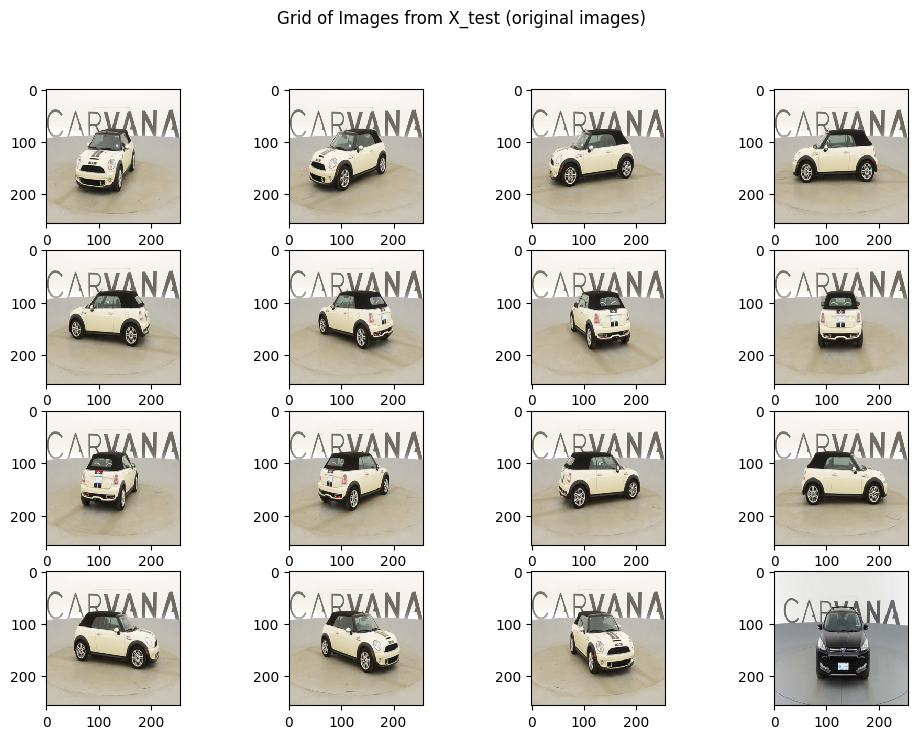

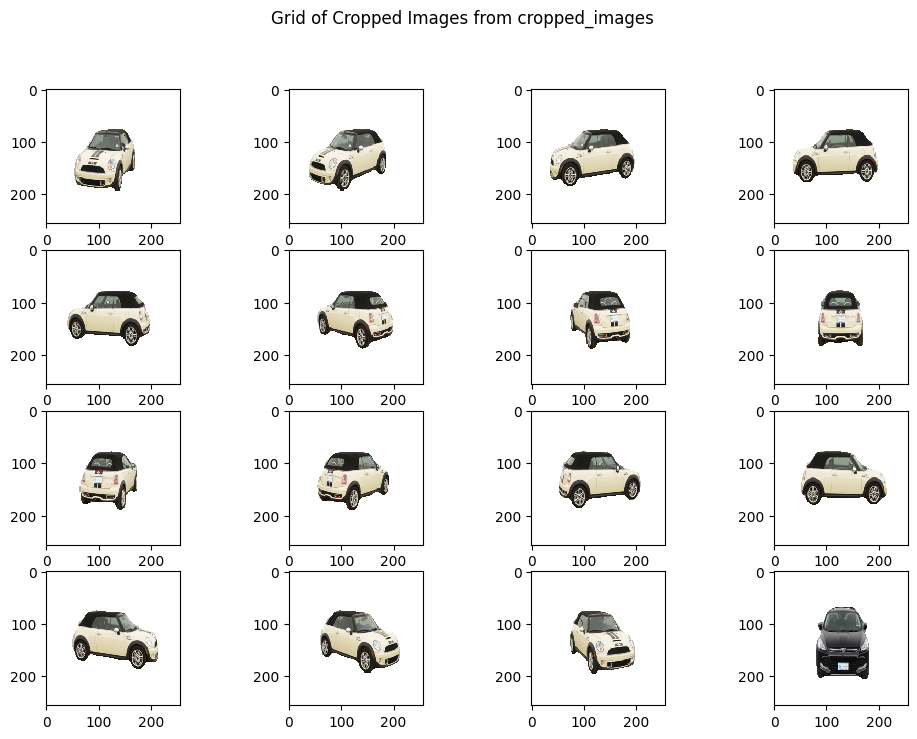

In [104]:
# Display first 16 outputs
columns = 4
rows = 4

cropped_images = []
for i in range(columns * rows +1): # can change to range(len(y_pred_rounded)) if we want to crop all of images
    cropped_image = remove_background(X_test[i],y_pred_rounded[i])
    if cropped_image.shape != (256, 256, 3):
        print("Cropped_image shape isn't correct")
    cropped_images.append(cropped_image)

fig_pred = plt.figure(figsize=(12, 8))
for i in range(1, columns*rows +1):
    ax = fig_pred.add_subplot(rows, columns, i)
    plt.imshow(X_test[i], cmap='gray', interpolation='nearest')
plt.suptitle("Grid of Images from X_test (original images)")
plt.show()

fig_test = plt.figure(figsize=(12, 8))
for i in range(1, columns*rows +1):
    ax = fig_test.add_subplot(rows, columns, i)
    plt.imshow(cropped_images[i], cmap='gray', interpolation='nearest')
plt.suptitle("Grid of Cropped Images from cropped_images")
plt.show()

# Display all of the variables used

In [92]:
%whos

Variable                         Type                 Data/Info
---------------------------------------------------------------
Image                            module               <module 'PIL.Image' from <...>e-packages/PIL/Image.py'>
K                                module               <module 'keras.backend' f<...>ras/backend/__init__.py'>
ReduceLROnPlateau                type                 <class 'keras.src.callbacks.ReduceLROnPlateau'>
X_test                           ndarray              1000x256x256x3: 196608000 elems, type `float64`, 1572864000 bytes (1500.0 Mb)
X_train                          ndarray              4000x256x256x3: 786432000 elems, type `float64`, 6291456000 bytes (6000.0 Mb)
average_dice_score               float                0.9925200653076172
ax                               Axes                 Axes(0.607197,0.11;0.233333x0.35)
columns                          int                  2
dice_compute                     function             <function dice_